<a href="https://colab.research.google.com/github/Ishan-A-Mardani/Music-Generation/blob/main/Music_Generation_LSTM_%F0%9F%8E%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install music21

In [ ]:
# Please ensure you have LilyPond installed on your system
us = environment.UserSettings()
us['lilypondPath'] = 'C:/Program Files (x86)/LilyPond/usr/bin/lilypond.exe'

In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
import os
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys

# LOADING DATA

For this project, I will be using MIDI files of classical piano music. The dataset includes various artists. I will be working with Frédéric Chopin's compositions.

* First of all, I make a list of all the songs in the Chopin folder parsed as music21 stream.

* Then I will be creating a function to extract chords and notes out of the data creating a corpus.

**Laoding and parsing data**

In [ ]:
#Loading the list of chopin's midi files as stream
filepath = "Data/classical_music_midi/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

c:\Users\Ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
c:\Users\Ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
c:\Users\Ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
c:\Users\Ishan\AppData\Local\Programs\Python\Pyth

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes.

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [ ]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

#Getting the list of notes as Corpus
Corpus = extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


So we have our data in the form of a corpus. A list of strings, if you will. Each string indicates a musical note. Let us explore this data corpus.

# DATA EXPLORATION

**In this section, I will be:**
* Exploring the data Corpus
* Examine all the notes in the Corpus
* Simplifying our Corpus to Built a working model

**Let us have a look at the first 50 values in our corpus**

In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['7.0', 'G3', '0.4', 'E3', '0.4.7', 'A4', '9.11', 'A4', 'G3', '5.7', '2.5', '2.5.7', 'A4', '9.0', 'A4', 'G3', '4.7', '0.4', '0.4.7', 'A4', '4.9', 'A4', 'B3', '4.7', '4.7', '4.7.11', 'C5', '0.5', 'E4', '4.9', '9.0', '9.0.4', '2', '2.6', 'E4', '9.0', 'C4', '9.0.4', '2', '5.7', 'E4', '7.11', 'B3', '4.7.11', '2', '2', '7', 'B3', '2.5', 'F3']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

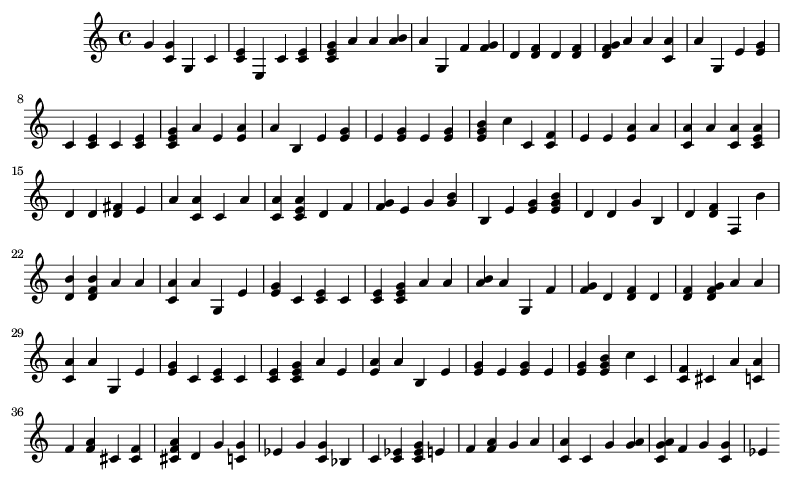

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music**

In [ ]:
Melody_Snippet.show('midi')

**Examine all the notes in the Corpus**

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody, so rare that it was played only once in the whole data.
Let us have a look at the frequency of the notes.
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

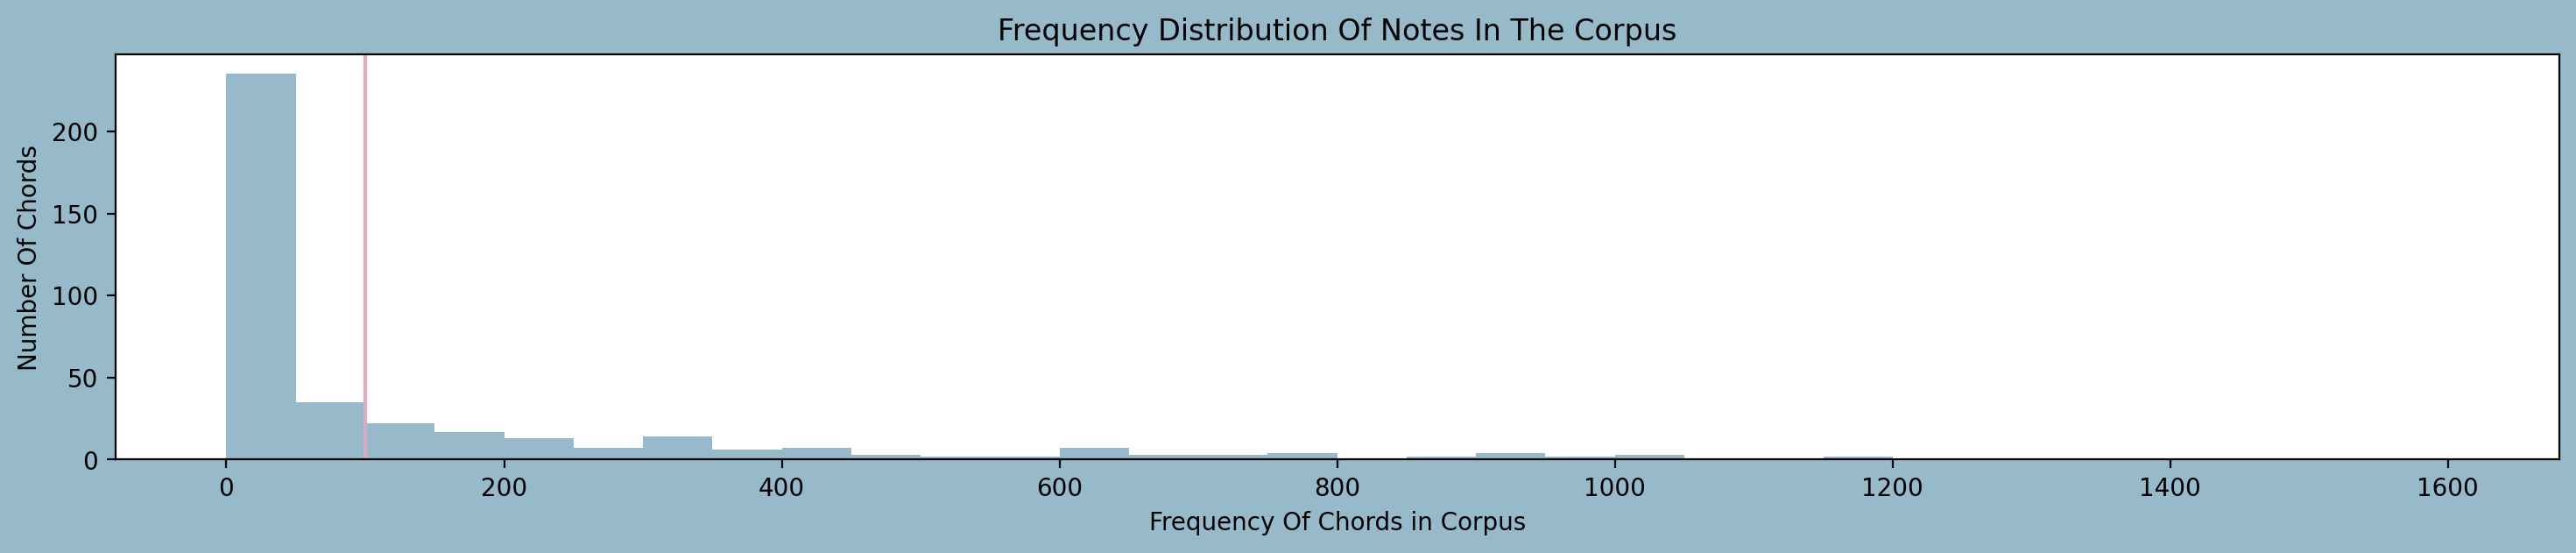

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section.

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elimination the rare notes:", len(Corpus))

Length of Corpus after elimination the rare notes: 53199


Finally! This is the cleaned data Corpus that I will be using for the music generation.  
In the next section, I will be preprocessing this Corpus for the training model.

The workflow for this project involves,

Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Music

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  



## DATA PREPROCESSING


**Creating a dictionary:** Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

**Encoding and Splitting the corpus:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify.

**Assigning X and y:** The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training.

**Splitting Train and Seed datasets** To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

**Creating a list of sorted unique characters**

In [ ]:
# Storing all the unique characters present in my corpus to build a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53753
Number of unique characters: 263


**Encoding and Splitting the Corpus as Labels and Targets**

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53713


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
print(X.shape)
# One hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

(53713, 40, 1)


**Splitting Train and Seed datasets**

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL BUILDING

I will be employing an LSTM for this project.

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)


c:\Users\Ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Model's Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 263)            │        67,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,973,511 (7.53 MB)

 Trainable params: 1,973,511 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 463ms/step - loss: 4.8988
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 446ms/step - loss: 4.6052
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 79s 472ms/step - loss: 4.5892
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 86s 510ms/step - loss: 4.5808
Epoch 5/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 79s 472ms/step - loss: 4.5675
Epoch 6/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - loss: 4.5696
Epoch 7/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 87s 518ms/step - loss: 4.5642
Epoch 8/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 86s 509ms/step - loss: 4.5631
Epoch 9/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 508ms/step - loss: 4.5532
Epoch 10/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 508ms/step - loss: 4.5464
Epoch 11/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 507ms/step - loss: 4.5555
Epoch 12/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - loss: 4.5409
Epoch 13/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - loss: 4.5456
Epoch 14/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 87s 515ms/step - loss: 4.5427
E

[Text(0.5, 0, 'Epochs')]

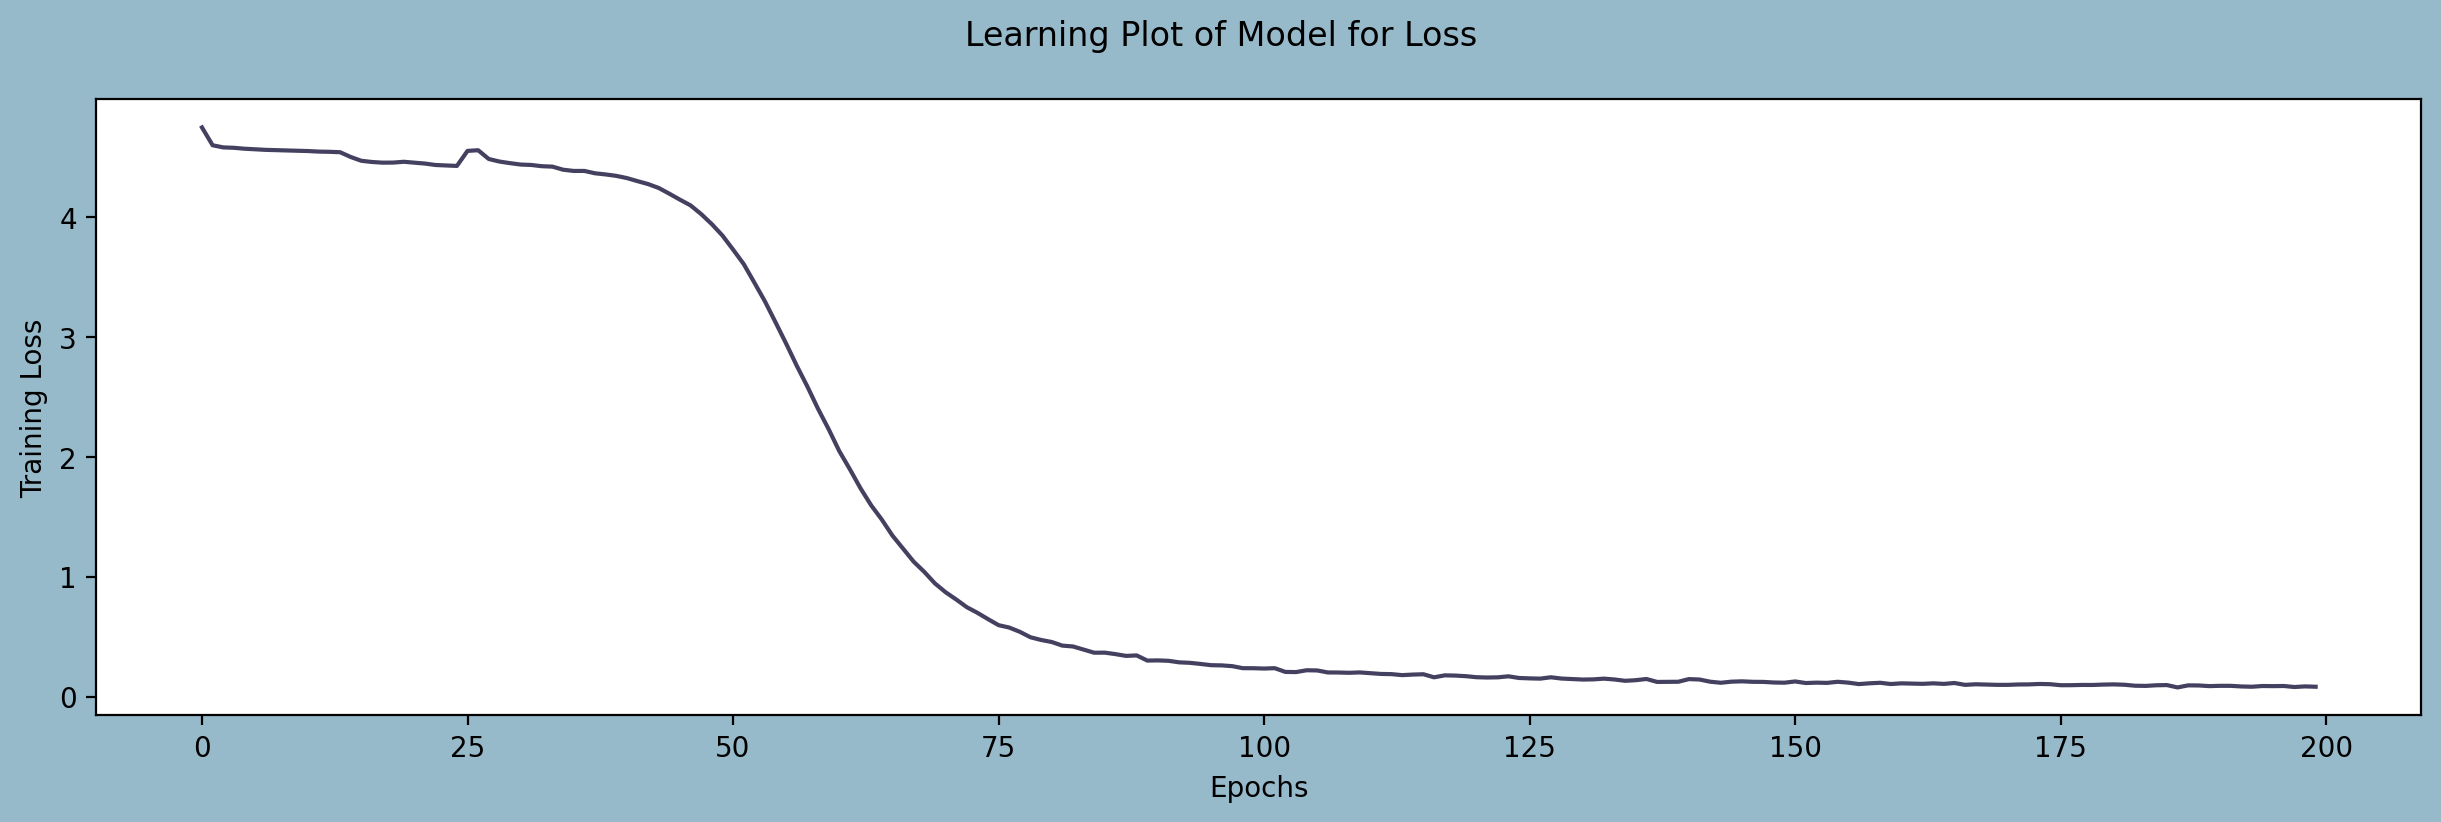

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)
model.save('model/my_model.h5')

#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# EVALUATING MODELS

Now that I have my model trained on the MIDI files of piano music, let us see how it performs.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves (the image above)
* The melody created

**Generating the Melody**

A function to obtain the generated music

C:\Users\Ishan\AppData\Local\Temp\ipykernel_80492\1871411629.py:8: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / 1.0 #diversity


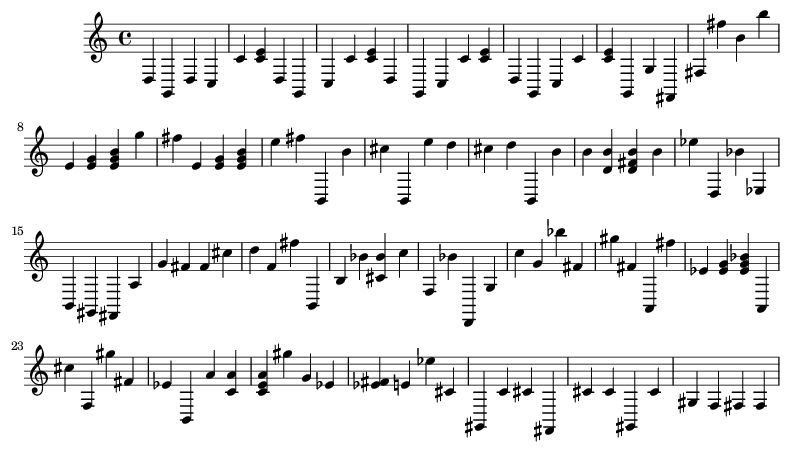

In [ ]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(100)
show(Melody)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file.

**Melody Generated Sample**

In [ ]:
Melody.show('midi')